Copyright (c) OpenMMLab. All rights reserved.

Modified from https://colab.research.google.com/github/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb

## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.

In [1]:
import sys

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install openmim
    !pip install -U openmim
    !mim install 'mmengine==0.1.0' 'mmcv>=2.0.0rc1'

    !git clone https://github.com/open-mmlab/mmselfsup.git
    %cd mmselfsup/
    !git checkout dev-1.x
    !pip install -e .

    sys.path.append('./mmselfsup')
    %cd demo
else:
    sys.path.append('..')

In [21]:
from argparse import ArgumentParser
from typing import Tuple, Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
from mmengine.dataset import Compose, default_collate

from mmselfsup.apis import inference_model, init_model
from mmselfsup.utils import register_all_modules

### Define utils

In [22]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def show_image(img: torch.Tensor, title: str = '') -> None:
    # image is [H, W, 3]
    assert img.shape[2] == 3

    plt.imshow(img)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def save_images(original_img: torch.Tensor, img_masked: torch.Tensor,
                pred_img: torch.Tensor, img_paste: torch.Tensor,
                out_file: Optional[str] =None) -> None:
    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 6]

    plt.subplot(1, 4, 1)
    show_image(original_img, 'original')

    plt.subplot(1, 4, 2)
    show_image(img_masked, 'masked')

    plt.subplot(1, 4, 3)
    show_image(pred_img, 'reconstruction')

    plt.subplot(1, 4, 4)
    show_image(img_paste, 'reconstruction + visible')

    if out_file is None:
        plt.show()
    else:
        plt.savefig(out_file)
        print(f'Images are saved to {out_file}')


def recover_norm(img: torch.Tensor,
                 mean: np.ndarray = imagenet_mean,
                 std: np.ndarray = imagenet_std):
    if mean is not None and std is not None:
        img = torch.clip((img * std + mean) * 255, 0, 255).int()
    return img


def post_process(
    original_img: torch.Tensor,
    pred_img: torch.Tensor,
    mask: torch.Tensor,
    mean: np.ndarray = imagenet_mean,
    std: np.ndarray = imagenet_std
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    # channel conversion
    original_img = torch.einsum('nchw->nhwc', original_img.cpu())
    # masked image
    img_masked = original_img * (1 - mask)
    # reconstructed image pasted with visible patches
    img_paste = original_img * (1 - mask) + pred_img * mask

    # muptiply std and add mean to each image
    original_img = recover_norm(original_img[0])
    img_masked = recover_norm(img_masked[0])

    pred_img = recover_norm(pred_img[0])
    img_paste = recover_norm(img_paste[0])

    return original_img, img_masked, pred_img, img_paste


### Load a pre-trained MAE model

In [4]:
# This is an MAE model trained with pixels as targets for visualization (ViT-large, training mask ratio=0.75)

# download checkpoint if not exist
# This ckpt is converted from https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth
!wget -nc https://download.openmmlab.com/mmselfsup/1.x/mae/mae_vit-large-p16_8xb512-fp16-coslr-1600e_in1k/mae_vit-large-p16_8xb512-fp16-coslr-1600e_in1k_20220825-cc7e98c9.pth

--2022-11-08 11:00:50--  https://download.openmmlab.com/mmselfsup/1.x/mae/mae_vit-large-p16_8xb512-fp16-coslr-1600e_in1k/mae_vit-large-p16_8xb512-fp16-coslr-1600e_in1k_20220825-cc7e98c9.pth
正在解析主机 download.openmmlab.com (download.openmmlab.com)... 47.102.71.233
正在连接 download.openmmlab.com (download.openmmlab.com)|47.102.71.233|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 1355429265 (1.3G) [application/octet-stream]
正在保存至: “mae_vit-large-p16_8xb512-fp16-coslr-1600e_in1k_20220825-cc7e98c9.pth”

e_in1k_20220825-cc7  99%[==================> ]   1.26G   913KB/s    剩余 0s    s 

In [5]:
ckpt_path = "mae_vit-large-p16_8xb512-fp16-coslr-1600e_in1k_20220825-cc7e98c9.pth"
model = init_model(
    '../configs/selfsup/mae/mae_vit-large-p16_8xb512-amp-coslr-1600e_in1k.py',
    ckpt_path,
    device='cpu')
print('Model loaded.')

local loads checkpoint from path: mae_vit-large-p16_8xb512-fp16-coslr-1600e_in1k_20220825-cc7e98c9.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

Model loaded.


### Load an image

In [6]:
# make random mask reproducible (comment out to make it change)
register_all_modules()
torch.manual_seed(2)

In [7]:
!wget -nc 'https://download.openmmlab.com/mmselfsup/mae/fox.jpg'

--2022-11-08 11:21:14--  https://download.openmmlab.com/mmselfsup/mae/fox.jpg
正在解析主机 download.openmmlab.com (download.openmmlab.com)... 47.102.71.233
正在连接 download.openmmlab.com (download.openmmlab.com)|47.102.71.233|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 60133 (59K) [image/jpeg]
正在保存至: “fox.jpg”

fox.jpg             100%[===================>]  58.72K  --.-KB/s    用时 0.05s   

2022-11-08 11:21:15 (1.08 MB/s) - 已保存 “fox.jpg” [60133/60133])



In [8]:
img_path = 'fox.jpg'

### Build Pipeline

In [10]:
model.cfg.test_dataloader = dict(
    dataset=dict(pipeline=[
        dict(type='LoadImageFromFile', file_client_args=dict(backend='disk')),
        dict(type='Resize', scale=(224, 224), backend='pillow'),
        dict(type='PackSelfSupInputs', meta_keys=['img_path'])
    ]))

vis_pipeline = Compose(model.cfg.test_dataloader.dataset.pipeline)

In [11]:
data = dict(img_path=img_path)
data = vis_pipeline(data)
data = default_collate([data])
img, _ = model.data_preprocessor(data, False)

### Reconstruction pipeline

In [12]:
# for MAE reconstruction
img_embedding = model.head.patchify(img[0])
# normalize the target image
mean = img_embedding.mean(dim=-1, keepdim=True)
std = (img_embedding.var(dim=-1, keepdim=True) + 1.e-6)**.5

In [16]:
# get reconstruction image
features = inference_model(model, img_path)
results = model.reconstruct(features, mean=mean, std=std)


In [17]:
original_target = img[0]
original_img, img_masked, pred_img, img_paste = post_process(
    original_target,
    results.pred.value,
    results.mask.value,
    mean=mean,
    std=std)


### Show the image

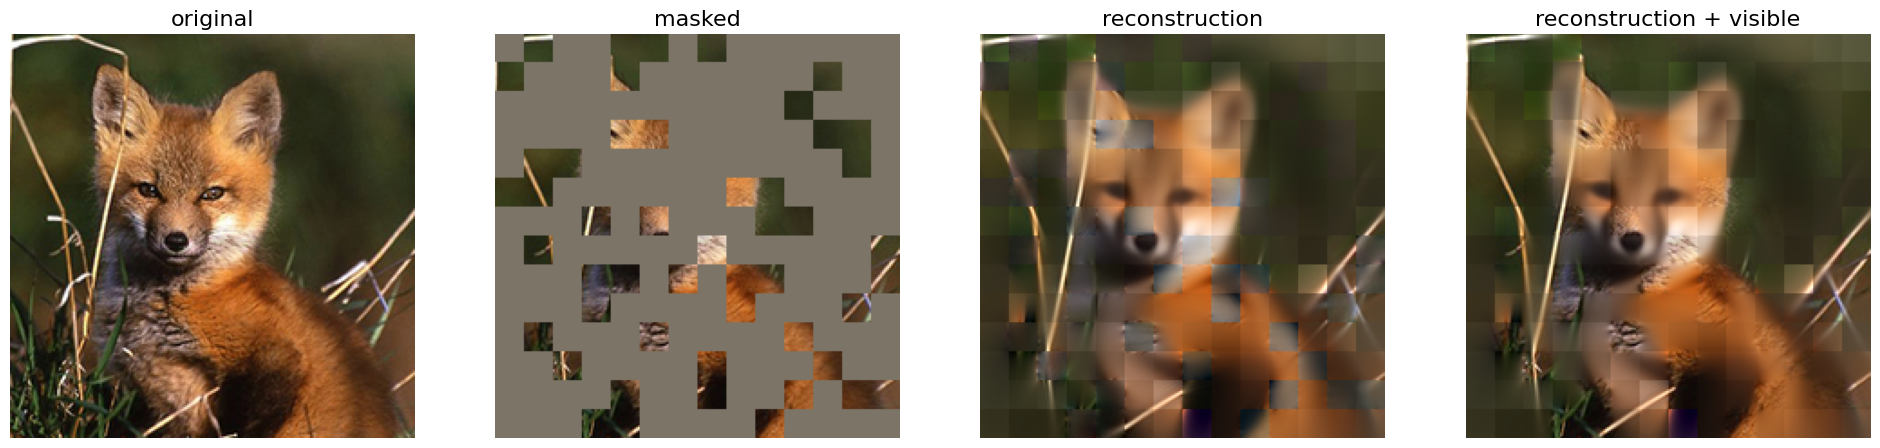

In [23]:
save_images(original_img, img_masked, pred_img, img_paste)